In [10]:
# Cell 1: Import required libraries and set up paths
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from pathlib import Path
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get the absolute path of the project root (two levels up from notebooks/notebooks)
project_root = Path(os.getcwd()).parent.parent

# Define paths relative to project root
input_path = project_root / "data" / "raw" / "parking_predictions_corrected.json"
output_path = project_root / "data" / "processed" / "parking_predictions_processed.parquet"

# Verify paths
print(f"Project root path: {project_root}")
print(f"Input file exists: {input_path.exists()}")
print(f"Input file path: {input_path}")
print(f"Output directory exists: {output_path.parent.exists()}")
print(f"Output file path: {output_path}")

# Ensure output directory exists
output_path.parent.mkdir(parents=True, exist_ok=True)

Project root path: /Users/adrianiraeguialvear/Desktop/OnSpotML_v2
Input file exists: True
Input file path: /Users/adrianiraeguialvear/Desktop/OnSpotML_v2/data/raw/parking_predictions_corrected.json
Output directory exists: True
Output file path: /Users/adrianiraeguialvear/Desktop/OnSpotML_v2/data/processed/parking_predictions_processed.parquet


In [18]:
# Cell 2: Define constants and helper functions
# Prediction code mapping
PREDICTION_CODE_MAPPING = {
    '0': 0,  # Unknown
    '1': 1,  # High (>80% free)
    '2': 2,  # Medium (30-80% free)
    '3': 3   # Low (<10% free)
}

# Time constants
TIMEZONE = pytz.timezone('Europe/Madrid')
INTERVAL_MINUTES = 5
START_HOUR = 8
END_HOUR = 20

def parse_prediction_string(pred_str, start_time):
    """
    Parse the prediction string into a list of tuples (timestamp, prediction_code)
    
    Args:
        pred_str (str): The prediction string from the JSON
        start_time (datetime): The start time for the predictions
    
    Returns:
        list: List of tuples (timestamp, prediction_code)
    """
    predictions = []
    current_time = start_time
    
    for pred_char in pred_str:
        if pred_char in PREDICTION_CODE_MAPPING:
            predictions.append((current_time, PREDICTION_CODE_MAPPING[pred_char]))
        current_time += timedelta(minutes=INTERVAL_MINUTES)
    
    return predictions


In [19]:
# Cell 3: Main data processing function
def process_parking_predictions(input_path, output_path):
    """
    Process the parking predictions JSON file into a tidy DataFrame
    
    Args:
        input_path (str): Path to the input JSON file
        output_path (str): Path to save the output Parquet file
    
    Returns:
        pd.DataFrame: Processed DataFrame
    """
    # Convert to Path objects
    input_path = Path(input_path)
    output_path = Path(output_path)
    
    # Validate input path
    if not input_path.exists():
        raise FileNotFoundError(f"Input file not found: {input_path}")
    
    logger.info(f"Loading data from {input_path}")
    
    # Load and parse JSON
    with open(str(input_path), 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Initialize list to store processed records
    processed_records = []
    
    # Access the data under OPENDATA_PSIU_APPARKB
    records = data['OPENDATA_PSIU_APPARKB']
    
    # Process each record
    for record in records:
        try:
            # Extract base information
            # Convert date from DD/MM/YYYY to YYYY-MM-DD format
            date_str = record['FH_INICIO']
            date_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M:%S')
            fh_inicio = TIMEZONE.localize(date_obj)
            
            # Process each tramo
            for tramo in record['TRAMOS']:
                for feature in tramo['features']:
                    properties = feature['properties']
                    geometry = feature['geometry']
                    
                    # Extract tramo information
                    tramo_info = {
                        'ID_TRAMO': properties['ID_TRAMO'],
                        'ADRECA': properties['TRAMO'],  # Using TRAMO as the address
                        'TIPO': properties['TIPO'],
                        'TARIFA': properties['TARIFA'],
                        'HORARIO': properties['HORARIO'],
                        'geometry': geometry
                    }
                    
                    # Parse predictions
                    predictions = parse_prediction_string(properties['PREDICCIONES'], fh_inicio)
                    
                    # Create records for each prediction
                    for timestamp, prediction_code in predictions:
                        record = tramo_info.copy()
                        record.update({
                            'timestamp': timestamp,
                            'prediction_code': prediction_code
                        })
                        processed_records.append(record)
        except Exception as e:
            logger.error(f"Error processing record: {e}")
            logger.error(f"Record content: {record}")
            raise
    
    # Create DataFrame
    df = pd.DataFrame(processed_records)
    
    # Sort by ID_TRAMO and timestamp
    df = df.sort_values(['ID_TRAMO', 'timestamp'])
    
    # Save to Parquet
    logger.info(f"Saving processed data to {output_path}")
    df.to_parquet(str(output_path), index=False)
    
    return df

In [20]:
# Cell 4: Execute the processing and display results
# Process the data
df = process_parking_predictions(input_path, output_path)

# Print summary information
logger.info("\nData Processing Summary:")
logger.info(f"Total records processed: {len(df)}")
logger.info(f"Unique ID_TRAMOs: {df['ID_TRAMO'].nunique()}")
logger.info(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
logger.info(f"Prediction code distribution:\n{df['prediction_code'].value_counts()}")

# Display sample of the processed data
print("\nSample of processed data:")
display(df.head())

INFO:__main__:Loading data from /Users/adrianiraeguialvear/Desktop/OnSpotML_v2/data/raw/parking_predictions_corrected.json
INFO:__main__:Saving processed data to /Users/adrianiraeguialvear/Desktop/OnSpotML_v2/data/processed/parking_predictions_processed.parquet
INFO:__main__:
Data Processing Summary:
INFO:__main__:Total records processed: 1837728
INFO:__main__:Unique ID_TRAMOs: 6381
INFO:__main__:Time range: 2024-09-17 08:00:00+02:00 to 2024-09-18 07:55:00+02:00
INFO:__main__:Prediction code distribution:
prediction_code
0    1802016
3      32097
1       2112
2       1503
Name: count, dtype: int64



Sample of processed data:


,ID_TRAMO,ADRECA,TIPO,TARIFA,HORARIO,geometry,timestamp,prediction_code
0,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'type': 'MultiLineString', 'coordinates': [[[...",2024-09-17 08:00:00+02:00,0
1,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'type': 'MultiLineString', 'coordinates': [[[...",2024-09-17 08:05:00+02:00,0
2,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'type': 'MultiLineString', 'coordinates': [[[...",2024-09-17 08:10:00+02:00,0
3,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'type': 'MultiLineString', 'coordinates': [[[...",2024-09-17 08:15:00+02:00,0
4,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'type': 'MultiLineString', 'coordinates': [[[...",2024-09-17 08:20:00+02:00,0


<Figure size 1500x600 with 0 Axes>

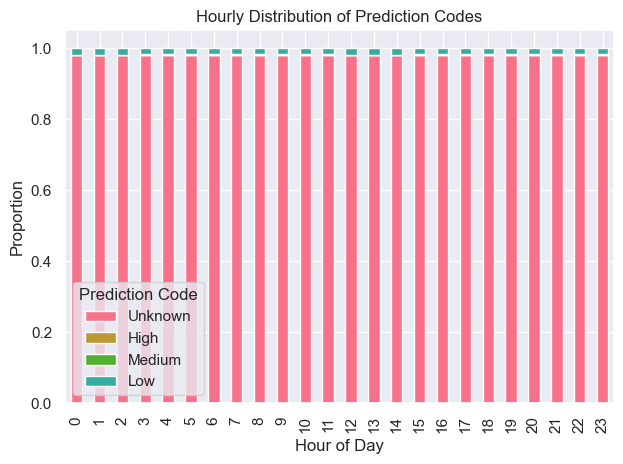


ID_TRAMO Activity Summary:
Average unknown proportion: 98.06%
Average low availability proportion: 1.75%
Number of ID_TRAMOs with any low availability predictions: 117
Number of ID_TRAMOs with any high availability predictions: 9


<Figure size 1500x600 with 0 Axes>

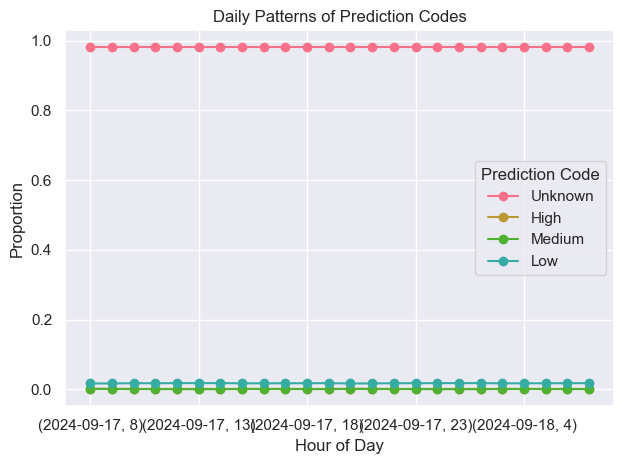

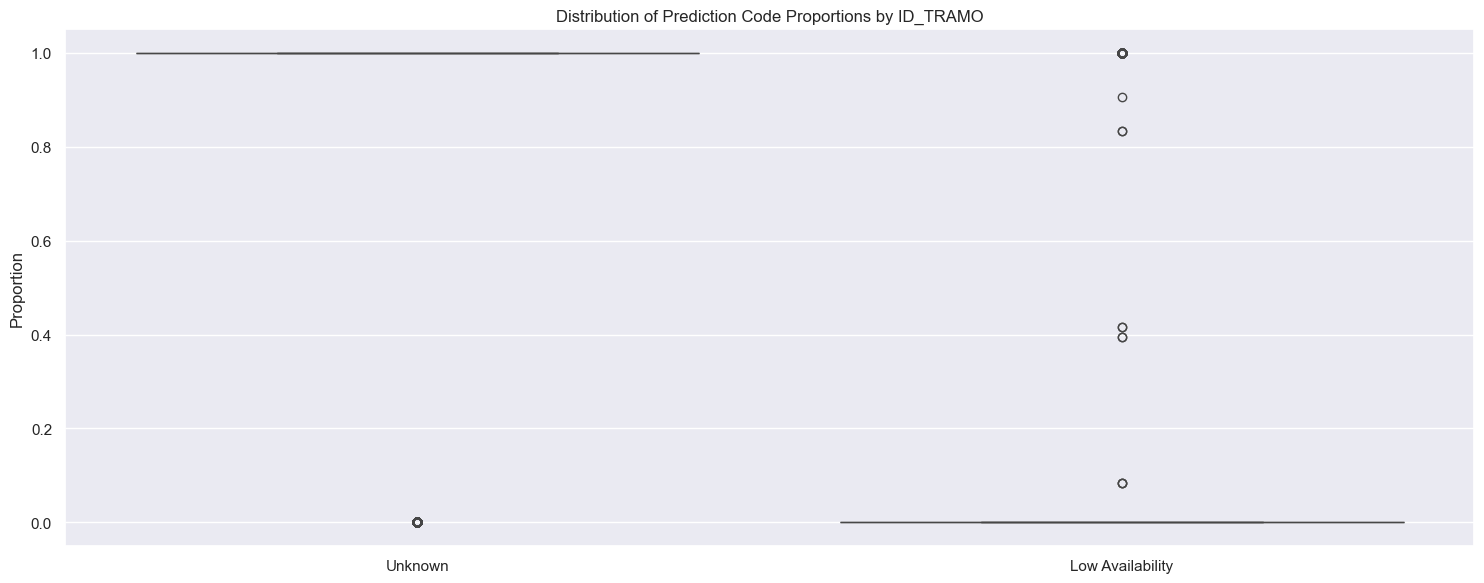

In [23]:
# Cell 5: Additional Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')  # Use default matplotlib style
sns.set_theme()  # This will set the seaborn theme
sns.set_palette('husl')  # Set color palette

# 1. Hourly distribution of predictions
df['hour'] = df['timestamp'].dt.hour
hourly_dist = df.groupby('hour')['prediction_code'].value_counts(normalize=True).unstack()

# Plot hourly distribution
plt.figure(figsize=(15, 6))
hourly_dist.plot(kind='bar', stacked=True)
plt.title('Hourly Distribution of Prediction Codes')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion')
plt.legend(title='Prediction Code', labels=['Unknown', 'High', 'Medium', 'Low'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 2. ID_TRAMO activity analysis
tramo_activity = df.groupby('ID_TRAMO')['prediction_code'].agg([
    ('total_predictions', 'count'),
    ('unknown_predictions', lambda x: (x == 0).sum()),
    ('low_availability', lambda x: (x == 3).sum()),
    ('medium_availability', lambda x: (x == 2).sum()),
    ('high_availability', lambda x: (x == 1).sum())
]).reset_index()

# Calculate proportions
tramo_activity['unknown_proportion'] = tramo_activity['unknown_predictions'] / tramo_activity['total_predictions']
tramo_activity['low_availability_proportion'] = tramo_activity['low_availability'] / tramo_activity['total_predictions']

# Print summary statistics
print("\nID_TRAMO Activity Summary:")
print(f"Average unknown proportion: {tramo_activity['unknown_proportion'].mean():.2%}")
print(f"Average low availability proportion: {tramo_activity['low_availability_proportion'].mean():.2%}")
print(f"Number of ID_TRAMOs with any low availability predictions: {len(tramo_activity[tramo_activity['low_availability'] > 0])}")
print(f"Number of ID_TRAMOs with any high availability predictions: {len(tramo_activity[tramo_activity['high_availability'] > 0])}")

# 3. Temporal patterns
df['date'] = df['timestamp'].dt.date
daily_patterns = df.groupby(['date', 'hour'])['prediction_code'].value_counts(normalize=True).unstack()

# Plot daily patterns
plt.figure(figsize=(15, 6))
daily_patterns.plot(kind='line', marker='o')
plt.title('Daily Patterns of Prediction Codes')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion')
plt.legend(title='Prediction Code', labels=['Unknown', 'High', 'Medium', 'Low'])
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Additional visualizations
# Distribution of prediction codes by ID_TRAMO
plt.figure(figsize=(15, 6))
sns.boxplot(data=tramo_activity[['unknown_proportion', 'low_availability_proportion']])
plt.title('Distribution of Prediction Code Proportions by ID_TRAMO')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Unknown', 'Low Availability'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()